<a href="https://colab.research.google.com/github/ufbfung/asia-flight-tracker/blob/main/Flight_Price_Tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cheapest Airport: JFK
Cheapest Airport Cost: 1423.0
Cheapest Destination: ICN - Seoul
Cheapest Destination Cost: 1423.0
Cheapest Cost: 1423.0
Average Cost: 2325.6923076923076
Median Cost: 2236.0
Highest Cost: 4107.0
Cheapest Start Date: 12/24/24
Cheapest End Date: 1/4/2025


<ipython-input-18-d3ab60028d7c>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Airport_Destination'] = df['Airport'] + ' - ' + df['Destination']


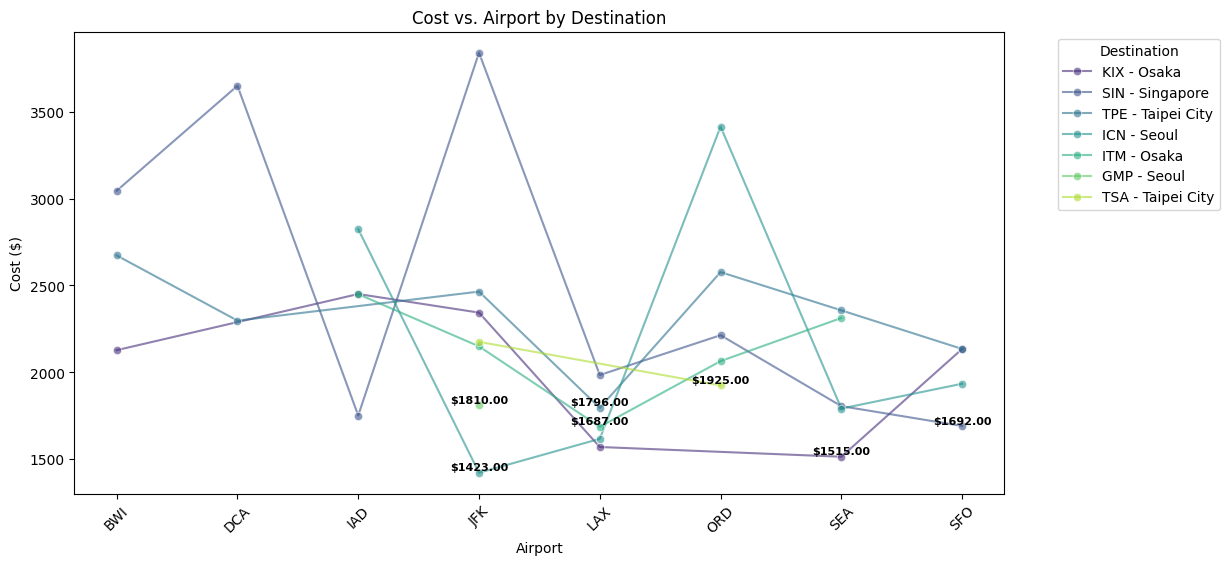

In [18]:
# Import libraries
import pandas as pd
import gspread
import seaborn as sns
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.auth import default
from gspread_dataframe import get_as_dataframe
import matplotlib.pyplot as plt

def auth_df_setup():
    # Authenticate
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)

    # Get spreadsheet
    spreadsheet = gc.open("Asia Flight Tracker 2024")
    worksheet = spreadsheet.worksheet('Tracker')

    # convert to df
    df = get_as_dataframe(worksheet)
    df = df.dropna(axis=1, how='all')

    # print
    df.head()

    return df

# Various analysis in table format
def analyze_flight_data(df):
    """
    Perform various analyses on flight cost data.

    Args:
    df (pd.DataFrame): The DataFrame containing flight data with columns
                       ['Airport', 'Destination', 'Cost', 'Start date', 'End date'].

    Returns:
    dict: A dictionary containing the results of the analyses.
    """
    # Clean the Cost column and convert to numeric, setting errors to NaN and dropping NaNs
    df['Cost'] = pd.to_numeric(df['Cost'].replace({'\$': '', ',': ''}, regex=True), errors='coerce')
    df = df.dropna(subset=['Cost'])

    # Analysis 1: Cheapest airport to fly out of and its cost
    cheapest_airport = df.loc[df['Cost'].idxmin()]['Airport']
    cheapest_airport_cost = df['Cost'].min()

    # Analysis 2: Cheapest destination to fly to and its cost
    cheapest_destination = df.loc[df['Cost'].idxmin()]['Destination']
    cheapest_destination_cost = df['Cost'].min()

    # Analysis 3: General distributions of costs
    cheapest_cost = df['Cost'].min()
    average_cost = df['Cost'].mean()
    median_cost = df['Cost'].median()
    highest_cost = df['Cost'].max()

    # Analysis 4: General start and end dates associated with each of the above
    row_cheapest = df.loc[df['Cost'].idxmin()]

    # Prepare the results
    results = {
        'Cheapest Airport': cheapest_airport,
        'Cheapest Airport Cost': cheapest_airport_cost,
        'Cheapest Destination': cheapest_destination,
        'Cheapest Destination Cost': cheapest_destination_cost,
        'Cheapest Cost': cheapest_cost,
        'Average Cost': average_cost,
        'Median Cost': median_cost,
        'Highest Cost': highest_cost,
        'Cheapest Start Date': row_cheapest['Start date'],
        'Cheapest End Date': row_cheapest['End date']
    }

    return results

def print_results(results):
    """
    Print the results dictionary with each key-value pair on a new line.

    Args:
    results (dict): The dictionary containing the results of the analyses.
    """
    for key, value in results.items():
        print(f"{key}: {value}")

def plot_flights2(df):
    # Ensure the Cost column is numeric and remove NaN values
    df['Cost'] = pd.to_numeric(df['Cost'].replace({'\$': '', ',': ''}, regex=True), errors='coerce')
    df = df.dropna(subset=['Cost'])

    # Find the cheapest flights for each airport and destination
    df['Airport_Destination'] = df['Airport'] + ' - ' + df['Destination']
    cheapest_flights_per_airport_destination = df.loc[df.groupby('Airport_Destination')['Cost'].idxmin()]

    # Create the base line plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Airport', y='Cost', hue='Destination', data=cheapest_flights_per_airport_destination, marker='o', palette='viridis', alpha=0.6)
    plt.title('Cost vs. Airport by Destination')
    plt.ylabel('Cost ($)')
    plt.xlabel('Airport')
    plt.xticks(rotation=45)

    # Find the cheapest flights for each destination
    cheapest_flights_per_destination = cheapest_flights_per_airport_destination.loc[cheapest_flights_per_airport_destination.groupby('Destination')['Cost'].idxmin()]

    # Add annotations for the cheapest flights per destination
    for index, row in cheapest_flights_per_destination.iterrows():
        plt.text(row['Airport'], row['Cost'], f"${row['Cost']:.2f}", color='black', ha='center', va='bottom', fontsize=8, weight='bold')

    # Customize the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), title='Destination', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

if __name__ == '__main__':
    # setup auth and extract spreadsheet
    df = auth_df_setup()

    # Table format of some useful flight insights
    results = analyze_flight_data(df)
    print_results(results)

    # Plot graph
    plot_flights2(df)
